In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
from probatus.feature_elimination import ShapRFECV

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]
print(training_data_df.shape)
training_data_df.head()

(3857227, 403)
Wall time: 1min 25s


,전용면적,금액(만원),층,건축년도,가격면적,target_log_transformed,targetarea_log_transformed,지번주소,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,철근콘크리트구조_fraction,철골철근콘크리트구조_fraction,벽돌구조_fraction,프리케스트콘크리트구조_fraction,경량철골구조_fraction,철골콘크리트구조_fraction,일반철골구조_fraction,블록구조_fraction,일반목구조_fraction,기타조적구조_fraction,기타강구조_fraction,강파이프구조_fraction,기타구조_fraction,석구조_fraction,기타콘크리트구조_fraction,라멘조_fraction,조립식판넬조_fraction,주_용도_공동주택_fraction,주_용도_종교시설_fraction,주_용도_제2종근린생활시설_fraction,주_용도_단독주택_fraction,주_용도_제1종근린생활시설_fraction,주_용도_교육연구시설_fraction,주_용도_판매시설_fraction,주_용도_노유자시설_fraction,주_용도_자동차관련시설_fraction,주_용도_업무시설_fraction,주_용도_운동시설_fraction,주_용도_창고시설_fraction,주_용도_문화및집회시설_fraction,주_용도_숙박시설_fraction,주_용도_근린생활시설_fraction,주_용도_위험물저장및처리시설_fraction,주_용도_동.식물관련시설_fraction,주_용도_의료시설_fraction,주_용도_공장_fraction,주_용도_관광휴게시설_fraction,주_용도_수련시설_fraction,주_용도_판매및영업시설_fraction,주_용도_교육연구및복지시설_fraction,지붕_평지붕_fraction,지붕_철콘지붕_fraction,지붕_경사지붕_fraction,지붕_기타지붕_fraction,지붕_기와지붕_fraction,지붕_판넬지붕_fraction,지붕_박공지붕_fraction,지붕_모임지붕_fraction,지붕_스페니쉬기와_fraction,지붕_슬레이트지붕_fraction,지붕_초가지붕_fraction,지붕_멘사드지붕_fraction,지붕_철골지붕_fraction,지붕_함석지붕_fraction,지붕_목구조지붕_fraction,지붕_원형지붕_fraction,지붕_금속지붕_fraction,지붕_전통지붕_fraction,지붕_비닐지붕_fraction,총외필지수,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥외기계식대수,옥내자주식대수,옥외자주식대수,총주차수,epi점수,친환경점수,호수대비연면적,호수대비주차수,층min,층max,층mean,층median,층norm,지하세대있음,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M~12M),소로2류(폭_8M~10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M~25M),중로2류(폭_15M~20M),중로3류(폭_12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,77.75,57000.0,2,1988,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2,77.75,77.75,77.75,0,7.666667,-0.866025,-0.500000,5579.095707,-9048.95

<AxesSubplot:>

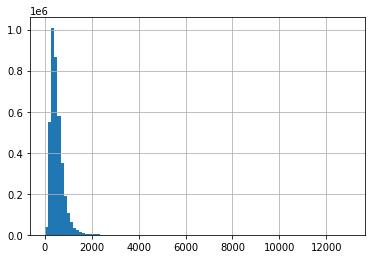

In [3]:
training_data_df['가격면적'].hist(bins=100)

In [4]:
training_data_df['가격면적'].describe()

count    3.857227e+06
mean     5.085237e+02
std      2.754056e+02
min      1.402464e+01
25%      3.243679e+02
50%      4.486317e+02
75%      6.229605e+02
max      1.300000e+04
Name: 가격면적, dtype: float64

In [5]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]
print(training_data_df.shape)
training_data_df.head()

(3672159, 403)


,전용면적,금액(만원),층,건축년도,가격면적,target_log_transformed,targetarea_log_transformed,지번주소,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,철근콘크리트구조_fraction,철골철근콘크리트구조_fraction,벽돌구조_fraction,프리케스트콘크리트구조_fraction,경량철골구조_fraction,철골콘크리트구조_fraction,일반철골구조_fraction,블록구조_fraction,일반목구조_fraction,기타조적구조_fraction,기타강구조_fraction,강파이프구조_fraction,기타구조_fraction,석구조_fraction,기타콘크리트구조_fraction,라멘조_fraction,조립식판넬조_fraction,주_용도_공동주택_fraction,주_용도_종교시설_fraction,주_용도_제2종근린생활시설_fraction,주_용도_단독주택_fraction,주_용도_제1종근린생활시설_fraction,주_용도_교육연구시설_fraction,주_용도_판매시설_fraction,주_용도_노유자시설_fraction,주_용도_자동차관련시설_fraction,주_용도_업무시설_fraction,주_용도_운동시설_fraction,주_용도_창고시설_fraction,주_용도_문화및집회시설_fraction,주_용도_숙박시설_fraction,주_용도_근린생활시설_fraction,주_용도_위험물저장및처리시설_fraction,주_용도_동.식물관련시설_fraction,주_용도_의료시설_fraction,주_용도_공장_fraction,주_용도_관광휴게시설_fraction,주_용도_수련시설_fraction,주_용도_판매및영업시설_fraction,주_용도_교육연구및복지시설_fraction,지붕_평지붕_fraction,지붕_철콘지붕_fraction,지붕_경사지붕_fraction,지붕_기타지붕_fraction,지붕_기와지붕_fraction,지붕_판넬지붕_fraction,지붕_박공지붕_fraction,지붕_모임지붕_fraction,지붕_스페니쉬기와_fraction,지붕_슬레이트지붕_fraction,지붕_초가지붕_fraction,지붕_멘사드지붕_fraction,지붕_철골지붕_fraction,지붕_함석지붕_fraction,지붕_목구조지붕_fraction,지붕_원형지붕_fraction,지붕_금속지붕_fraction,지붕_전통지붕_fraction,지붕_비닐지붕_fraction,총외필지수,총건축면적,총연면적,총용적률연면적,총호수,주건축물수,부속건축물수,부속건축물면적,옥내기계식대수,옥외기계식대수,옥내자주식대수,옥외자주식대수,총주차수,epi점수,친환경점수,호수대비연면적,호수대비주차수,층min,층max,층mean,층median,층norm,지하세대있음,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고등학교,고속철도,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타시장시설,기타용도지역지구기타,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,박물관,방송통신시설,방수설비,방재지구,방화지구,변전소(전원개발사업구역),변전시설,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M~12M),소로2류(폭_8M~10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,아파트지구,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,운동장,원추표면구역,원형보존지,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차전용도로,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(전술항공5km),제한보호구역(후방지역500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거용지,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M~25M),중로2류(폭_15M~20M),중로3류(폭_12M~15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,철도,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,통제보호구역,통제보호구역(민통선이남300m),특수도로(보행자전용도로),특정개발진흥지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역
0,77.75,57000.0,2,1988,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2,77.75,77.75,77.75,0,7.666667,-0.866025,-0.500000,5579.095707,-9048.95

<AxesSubplot:>

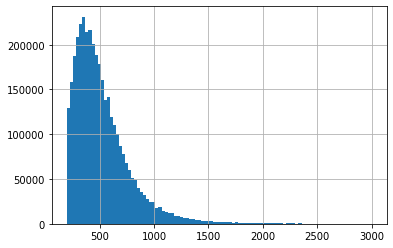

In [6]:
training_data_df['가격면적'].hist(bins=100)

In [7]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [8]:
training_data_df['호수대비부속건축물면적'].describe()

count    3.672159e+06
mean     4.874879e+01
std      1.322271e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.191623e+01
max      5.266776e+04
Name: 호수대비부속건축물면적, dtype: float64

<AxesSubplot:>

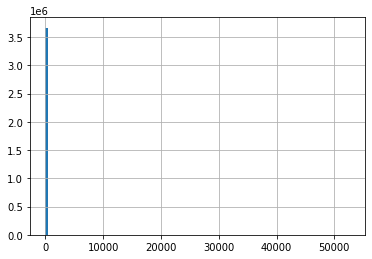

In [9]:
training_data_df['호수대비부속건축물면적'].hist(bins=100)

In [10]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [11]:
training_data_df.shape

(3658226, 404)

In [12]:
training_data_df = training_data_df.reset_index(drop=True)

In [13]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [14]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

,colname
0,trade_type
1,표준지여부
2,건물나이
3,지목명
4,용도지역명1


In [15]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [16]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [17]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

# Training

In [18]:
from sklearn.model_selection import KFold, GroupKFold

In [19]:
import lightgbm as lgb

In [20]:
from sklearn.metrics import r2_score

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

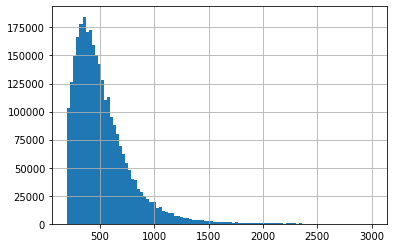

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.991137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 170.749
[100]	valid_0's huber: 168.611
[150]	valid_0's huber: 166.519
[200]	valid_0's huber: 164.462
[250]	valid_0's huber: 162.43
[300]	valid_0's huber: 160.433
[350]	valid_0's huber: 158.477
[400]	valid_0's huber: 156.561
[450]	valid_0's huber: 154.677
[500]	valid_0's huber: 152.809
[550]	valid_0's huber: 150.975
[600]	valid_0's huber: 149.178
[650]	valid_0's huber: 147.406
[700]	valid_0's huber: 145.658
[750]	valid_0's huber: 143.95
[800]	valid_0's huber: 142.272
[850]	valid_0's huber: 140.625
[900]	valid_0's huber: 139.011
[950]	valid_0's huber: 137.422
[1000]	valid_0's huber: 135.867
[1050]	valid_0's huber: 134.337
[1100]	valid_0's huber: 132.839
[1150]	valid_0's huber: 131.375
[1200]	valid_0's huber: 129.948
[1250]	valid_0's huber: 128.555
[1300]	valid_0's huber: 127.182
[1350]	valid_0's huber: 125.831
[1400]	valid_0's huber: 124.517
[1450]	va

[12700]	valid_0's huber: 60.6097
[12750]	valid_0's huber: 60.5464
[12800]	valid_0's huber: 60.4864
[12850]	valid_0's huber: 60.4278
[12900]	valid_0's huber: 60.37
[12950]	valid_0's huber: 60.3115
[13000]	valid_0's huber: 60.2536
[13050]	valid_0's huber: 60.1952
[13100]	valid_0's huber: 60.1386
[13150]	valid_0's huber: 60.0828
[13200]	valid_0's huber: 60.0281
[13250]	valid_0's huber: 59.962
[13300]	valid_0's huber: 59.9094
[13350]	valid_0's huber: 59.8502
[13400]	valid_0's huber: 59.7897
[13450]	valid_0's huber: 59.7308
[13500]	valid_0's huber: 59.6765
[13550]	valid_0's huber: 59.6253
[13600]	valid_0's huber: 59.5721
[13650]	valid_0's huber: 59.5194
[13700]	valid_0's huber: 59.466
[13750]	valid_0's huber: 59.4142
[13800]	valid_0's huber: 59.3646
[13850]	valid_0's huber: 59.3144
[13900]	valid_0's huber: 59.2652
[13950]	valid_0's huber: 59.2125
[14000]	valid_0's huber: 59.1608
[14050]	valid_0's huber: 59.1111
[14100]	valid_0's huber: 59.0621
[14150]	valid_0's huber: 59.0138
[14200]	valid_

[25200]	valid_0's huber: 51.9849
[25250]	valid_0's huber: 51.9661
[25300]	valid_0's huber: 51.9471
[25350]	valid_0's huber: 51.9282
[25400]	valid_0's huber: 51.9109
[25450]	valid_0's huber: 51.8929
[25500]	valid_0's huber: 51.8752
[25550]	valid_0's huber: 51.8571
[25600]	valid_0's huber: 51.8375
[25650]	valid_0's huber: 51.8152
[25700]	valid_0's huber: 51.7938
[25750]	valid_0's huber: 51.7751
[25800]	valid_0's huber: 51.7563
[25850]	valid_0's huber: 51.7377
[25900]	valid_0's huber: 51.7184
[25950]	valid_0's huber: 51.6995
[26000]	valid_0's huber: 51.6808
[26050]	valid_0's huber: 51.6611
[26100]	valid_0's huber: 51.6406
[26150]	valid_0's huber: 51.6203
[26200]	valid_0's huber: 51.602
[26250]	valid_0's huber: 51.5836
[26300]	valid_0's huber: 51.5655
[26350]	valid_0's huber: 51.5457
[26400]	valid_0's huber: 51.5274
[26450]	valid_0's huber: 51.5094
[26500]	valid_0's huber: 51.4905
[26550]	valid_0's huber: 51.4729
[26600]	valid_0's huber: 51.4544
[26650]	valid_0's huber: 51.4351
[26700]	val

[37700]	valid_0's huber: 48.3999
[37750]	valid_0's huber: 48.3936
[37800]	valid_0's huber: 48.3873
[37850]	valid_0's huber: 48.3798
[37900]	valid_0's huber: 48.3713
[37950]	valid_0's huber: 48.3612
[38000]	valid_0's huber: 48.3508
[38050]	valid_0's huber: 48.3401
[38100]	valid_0's huber: 48.3285
[38150]	valid_0's huber: 48.3171
[38200]	valid_0's huber: 48.3061
[38250]	valid_0's huber: 48.2945
[38300]	valid_0's huber: 48.2846
[38350]	valid_0's huber: 48.2733
[38400]	valid_0's huber: 48.2625
[38450]	valid_0's huber: 48.2513
[38500]	valid_0's huber: 48.2419
[38550]	valid_0's huber: 48.2319
[38600]	valid_0's huber: 48.222
[38650]	valid_0's huber: 48.2117
[38700]	valid_0's huber: 48.2016
[38750]	valid_0's huber: 48.191
[38800]	valid_0's huber: 48.1812
[38850]	valid_0's huber: 48.1719
[38900]	valid_0's huber: 48.1623
[38950]	valid_0's huber: 48.1524
[39000]	valid_0's huber: 48.1406
[39050]	valid_0's huber: 48.1301
[39100]	valid_0's huber: 48.1205
[39150]	valid_0's huber: 48.1101
[39200]	vali

[50200]	valid_0's huber: 46.2325
[50250]	valid_0's huber: 46.2245
[50300]	valid_0's huber: 46.2171
[50350]	valid_0's huber: 46.2115
[50400]	valid_0's huber: 46.2047
[50450]	valid_0's huber: 46.1969
[50500]	valid_0's huber: 46.1892
[50550]	valid_0's huber: 46.1818
[50600]	valid_0's huber: 46.175
[50650]	valid_0's huber: 46.1685
[50700]	valid_0's huber: 46.1618
[50750]	valid_0's huber: 46.155
[50800]	valid_0's huber: 46.1488
[50850]	valid_0's huber: 46.1427
[50900]	valid_0's huber: 46.136
[50950]	valid_0's huber: 46.1296
[51000]	valid_0's huber: 46.1223
[51050]	valid_0's huber: 46.1152
[51100]	valid_0's huber: 46.1081
[51150]	valid_0's huber: 46.1017
[51200]	valid_0's huber: 46.0939
[51250]	valid_0's huber: 46.0827
[51300]	valid_0's huber: 46.072
[51350]	valid_0's huber: 46.0613
[51400]	valid_0's huber: 46.051
[51450]	valid_0's huber: 46.0407
[51500]	valid_0's huber: 46.0308
[51550]	valid_0's huber: 46.0194
[51600]	valid_0's huber: 46.01
[51650]	valid_0's huber: 46.001
[51700]	valid_0's 

[62700]	valid_0's huber: 44.6038
[62750]	valid_0's huber: 44.5984
[62800]	valid_0's huber: 44.5928
[62850]	valid_0's huber: 44.5863
[62900]	valid_0's huber: 44.5807
[62950]	valid_0's huber: 44.5751
[63000]	valid_0's huber: 44.5693
[63050]	valid_0's huber: 44.5636
[63100]	valid_0's huber: 44.5582
[63150]	valid_0's huber: 44.5529
[63200]	valid_0's huber: 44.5475
[63250]	valid_0's huber: 44.5431
[63300]	valid_0's huber: 44.5374
[63350]	valid_0's huber: 44.5312
[63400]	valid_0's huber: 44.5257
[63450]	valid_0's huber: 44.5187
[63500]	valid_0's huber: 44.5124
[63550]	valid_0's huber: 44.5069
[63600]	valid_0's huber: 44.5014
[63650]	valid_0's huber: 44.4961
[63700]	valid_0's huber: 44.4909
[63750]	valid_0's huber: 44.4859
[63800]	valid_0's huber: 44.4816
[63850]	valid_0's huber: 44.477
[63900]	valid_0's huber: 44.4725
[63950]	valid_0's huber: 44.4671
[64000]	valid_0's huber: 44.4606
[64050]	valid_0's huber: 44.4545
[64100]	valid_0's huber: 44.449
[64150]	valid_0's huber: 44.4428
[64200]	vali

[75200]	valid_0's huber: 43.3012
[75250]	valid_0's huber: 43.2966
[75300]	valid_0's huber: 43.2922
[75350]	valid_0's huber: 43.2876
[75400]	valid_0's huber: 43.2833
[75450]	valid_0's huber: 43.2792
[75500]	valid_0's huber: 43.275
[75550]	valid_0's huber: 43.2703
[75600]	valid_0's huber: 43.2655
[75650]	valid_0's huber: 43.2603
[75700]	valid_0's huber: 43.2551
[75750]	valid_0's huber: 43.2502
[75800]	valid_0's huber: 43.2451
[75850]	valid_0's huber: 43.2395
[75900]	valid_0's huber: 43.2344
[75950]	valid_0's huber: 43.2289
[76000]	valid_0's huber: 43.2237
[76050]	valid_0's huber: 43.219
[76100]	valid_0's huber: 43.2154
[76150]	valid_0's huber: 43.2108
[76200]	valid_0's huber: 43.2053
[76250]	valid_0's huber: 43.2006
[76300]	valid_0's huber: 43.1957
[76350]	valid_0's huber: 43.1909
[76400]	valid_0's huber: 43.1862
[76450]	valid_0's huber: 43.1813
[76500]	valid_0's huber: 43.1762
[76550]	valid_0's huber: 43.1736
[76600]	valid_0's huber: 43.1682
[76650]	valid_0's huber: 43.1632
[76700]	vali

[87700]	valid_0's huber: 42.3075
[87750]	valid_0's huber: 42.3043
[87800]	valid_0's huber: 42.3005
[87850]	valid_0's huber: 42.2962
[87900]	valid_0's huber: 42.2927
[87950]	valid_0's huber: 42.2888
[88000]	valid_0's huber: 42.2845
[88050]	valid_0's huber: 42.28
[88100]	valid_0's huber: 42.2758
[88150]	valid_0's huber: 42.272
[88200]	valid_0's huber: 42.2682
[88250]	valid_0's huber: 42.2642
[88300]	valid_0's huber: 42.2602
[88350]	valid_0's huber: 42.2558
[88400]	valid_0's huber: 42.2503
[88450]	valid_0's huber: 42.2459
[88500]	valid_0's huber: 42.2418
[88550]	valid_0's huber: 42.2375
[88600]	valid_0's huber: 42.2334
[88650]	valid_0's huber: 42.2288
[88700]	valid_0's huber: 42.2242
[88750]	valid_0's huber: 42.2206
[88800]	valid_0's huber: 42.2168
[88850]	valid_0's huber: 42.2125
[88900]	valid_0's huber: 42.2089
[88950]	valid_0's huber: 42.2046
[89000]	valid_0's huber: 42.2004
[89050]	valid_0's huber: 42.197
[89100]	valid_0's huber: 42.1946
[89150]	valid_0's huber: 42.1924
[89200]	valid_

[100150]	valid_0's huber: 41.4529
[100200]	valid_0's huber: 41.4505
[100250]	valid_0's huber: 41.4477
[100300]	valid_0's huber: 41.4446
[100350]	valid_0's huber: 41.4411
[100400]	valid_0's huber: 41.4382
[100450]	valid_0's huber: 41.4351
[100500]	valid_0's huber: 41.4316
[100550]	valid_0's huber: 41.4283
[100600]	valid_0's huber: 41.4252
[100650]	valid_0's huber: 41.4223
[100700]	valid_0's huber: 41.4207
[100750]	valid_0's huber: 41.4193
[100800]	valid_0's huber: 41.4176
[100850]	valid_0's huber: 41.4162
[100900]	valid_0's huber: 41.4148
[100950]	valid_0's huber: 41.4134
[101000]	valid_0's huber: 41.4121
[101050]	valid_0's huber: 41.4107
[101100]	valid_0's huber: 41.4093
[101150]	valid_0's huber: 41.4078
[101200]	valid_0's huber: 41.4065
[101250]	valid_0's huber: 41.4049
[101300]	valid_0's huber: 41.4036
[101350]	valid_0's huber: 41.4024
[101400]	valid_0's huber: 41.4013
[101450]	valid_0's huber: 41.3999
[101500]	valid_0's huber: 41.3979
[101550]	valid_0's huber: 41.3955
[101600]	valid

[112250]	valid_0's huber: 40.7849
[112300]	valid_0's huber: 40.7816
[112350]	valid_0's huber: 40.7783
[112400]	valid_0's huber: 40.7754
[112450]	valid_0's huber: 40.7727
[112500]	valid_0's huber: 40.7706
[112550]	valid_0's huber: 40.7687
[112600]	valid_0's huber: 40.7666
[112650]	valid_0's huber: 40.7645
[112700]	valid_0's huber: 40.7617
[112750]	valid_0's huber: 40.7592
[112800]	valid_0's huber: 40.7564
[112850]	valid_0's huber: 40.7531
[112900]	valid_0's huber: 40.7494
[112950]	valid_0's huber: 40.7461
[113000]	valid_0's huber: 40.7424
[113050]	valid_0's huber: 40.7386
[113100]	valid_0's huber: 40.7353
[113150]	valid_0's huber: 40.7319
[113200]	valid_0's huber: 40.7292
[113250]	valid_0's huber: 40.7263
[113300]	valid_0's huber: 40.7226
[113350]	valid_0's huber: 40.7199
[113400]	valid_0's huber: 40.717
[113450]	valid_0's huber: 40.7132
[113500]	valid_0's huber: 40.71
[113550]	valid_0's huber: 40.707
[113600]	valid_0's huber: 40.7038
[113650]	valid_0's huber: 40.7008
[113700]	valid_0's

[124350]	valid_0's huber: 40.1939
[124400]	valid_0's huber: 40.1925
[124450]	valid_0's huber: 40.1907
[124500]	valid_0's huber: 40.1892
[124550]	valid_0's huber: 40.1879
[124600]	valid_0's huber: 40.1868
[124650]	valid_0's huber: 40.1855
[124700]	valid_0's huber: 40.1841
[124750]	valid_0's huber: 40.1828
[124800]	valid_0's huber: 40.1816
[124850]	valid_0's huber: 40.1805
[124900]	valid_0's huber: 40.179
[124950]	valid_0's huber: 40.1773
[125000]	valid_0's huber: 40.1749
[125050]	valid_0's huber: 40.1727
[125100]	valid_0's huber: 40.1706
[125150]	valid_0's huber: 40.1694
[125200]	valid_0's huber: 40.1679
[125250]	valid_0's huber: 40.1656
[125300]	valid_0's huber: 40.1641
[125350]	valid_0's huber: 40.1628
[125400]	valid_0's huber: 40.1617
[125450]	valid_0's huber: 40.1604
[125500]	valid_0's huber: 40.1594
[125550]	valid_0's huber: 40.1583
[125600]	valid_0's huber: 40.1573
[125650]	valid_0's huber: 40.1562
[125700]	valid_0's huber: 40.1549
[125750]	valid_0's huber: 40.1534
[125800]	valid_

[136450]	valid_0's huber: 39.6928
[136500]	valid_0's huber: 39.6902
[136550]	valid_0's huber: 39.6879
[136600]	valid_0's huber: 39.6859
[136650]	valid_0's huber: 39.6837
[136700]	valid_0's huber: 39.6814
[136750]	valid_0's huber: 39.679
[136800]	valid_0's huber: 39.6768
[136850]	valid_0's huber: 39.6746
[136900]	valid_0's huber: 39.6725
[136950]	valid_0's huber: 39.6704
[137000]	valid_0's huber: 39.668
[137050]	valid_0's huber: 39.6657
[137100]	valid_0's huber: 39.6633
[137150]	valid_0's huber: 39.6609
[137200]	valid_0's huber: 39.6584
[137250]	valid_0's huber: 39.6559
[137300]	valid_0's huber: 39.6534
[137350]	valid_0's huber: 39.6509
[137400]	valid_0's huber: 39.6489
[137450]	valid_0's huber: 39.6465
[137500]	valid_0's huber: 39.644
[137550]	valid_0's huber: 39.6417
[137600]	valid_0's huber: 39.6398
[137650]	valid_0's huber: 39.6374
[137700]	valid_0's huber: 39.635
[137750]	valid_0's huber: 39.6324
[137800]	valid_0's huber: 39.6299
[137850]	valid_0's huber: 39.6275
[137900]	valid_0's

[148550]	valid_0's huber: 39.1969
[148600]	valid_0's huber: 39.1949
[148650]	valid_0's huber: 39.193
[148700]	valid_0's huber: 39.191
[148750]	valid_0's huber: 39.1886
[148800]	valid_0's huber: 39.1863
[148850]	valid_0's huber: 39.1842
[148900]	valid_0's huber: 39.1824
[148950]	valid_0's huber: 39.181
[149000]	valid_0's huber: 39.1788
[149050]	valid_0's huber: 39.1766
[149100]	valid_0's huber: 39.1742
[149150]	valid_0's huber: 39.1722
[149200]	valid_0's huber: 39.1698
[149250]	valid_0's huber: 39.1677
[149300]	valid_0's huber: 39.1656
[149350]	valid_0's huber: 39.1636
[149400]	valid_0's huber: 39.1614
[149450]	valid_0's huber: 39.1595
[149500]	valid_0's huber: 39.157
[149550]	valid_0's huber: 39.1548
[149600]	valid_0's huber: 39.1523
[149650]	valid_0's huber: 39.15
[149700]	valid_0's huber: 39.1477
[149750]	valid_0's huber: 39.1455
[149800]	valid_0's huber: 39.1433
[149850]	valid_0's huber: 39.1417
[149900]	valid_0's huber: 39.1404
[149950]	valid_0's huber: 39.1384
[150000]	valid_0's h

[160700]	valid_0's huber: 38.7445
[160750]	valid_0's huber: 38.7428
[160800]	valid_0's huber: 38.7412
[160850]	valid_0's huber: 38.7397
[160900]	valid_0's huber: 38.7381
[160950]	valid_0's huber: 38.7362
[161000]	valid_0's huber: 38.7343
[161050]	valid_0's huber: 38.7321
[161100]	valid_0's huber: 38.7304
[161150]	valid_0's huber: 38.7289
[161200]	valid_0's huber: 38.728
[161250]	valid_0's huber: 38.7272
[161300]	valid_0's huber: 38.7256
[161350]	valid_0's huber: 38.7238
[161400]	valid_0's huber: 38.7221
[161450]	valid_0's huber: 38.7205
[161500]	valid_0's huber: 38.7189
[161550]	valid_0's huber: 38.7173
[161600]	valid_0's huber: 38.7155
[161650]	valid_0's huber: 38.7135
[161700]	valid_0's huber: 38.7116
[161750]	valid_0's huber: 38.7097
[161800]	valid_0's huber: 38.7078
[161850]	valid_0's huber: 38.7062
[161900]	valid_0's huber: 38.7044
[161950]	valid_0's huber: 38.7028
[162000]	valid_0's huber: 38.7011
[162050]	valid_0's huber: 38.6994
[162100]	valid_0's huber: 38.6977
[162150]	valid_

[172800]	valid_0's huber: 38.3509
[172850]	valid_0's huber: 38.3505
[172900]	valid_0's huber: 38.3494
[172950]	valid_0's huber: 38.3478
[173000]	valid_0's huber: 38.3461
[173050]	valid_0's huber: 38.3444
[173100]	valid_0's huber: 38.3427
[173150]	valid_0's huber: 38.3409
[173200]	valid_0's huber: 38.3393
[173250]	valid_0's huber: 38.3378
[173300]	valid_0's huber: 38.3361
[173350]	valid_0's huber: 38.3344
[173400]	valid_0's huber: 38.3326
[173450]	valid_0's huber: 38.3306
[173500]	valid_0's huber: 38.3291
[173550]	valid_0's huber: 38.3276
[173600]	valid_0's huber: 38.326
[173650]	valid_0's huber: 38.3246
[173700]	valid_0's huber: 38.323
[173750]	valid_0's huber: 38.3216
[173800]	valid_0's huber: 38.32
[173850]	valid_0's huber: 38.3184
[173900]	valid_0's huber: 38.3168
[173950]	valid_0's huber: 38.3152
[174000]	valid_0's huber: 38.314
[174050]	valid_0's huber: 38.3125
[174100]	valid_0's huber: 38.3112
[174150]	valid_0's huber: 38.3095
[174200]	valid_0's huber: 38.3077
[174250]	valid_0's 

[184900]	valid_0's huber: 37.9929
[184950]	valid_0's huber: 37.9913
[185000]	valid_0's huber: 37.9897
[185050]	valid_0's huber: 37.9883
[185100]	valid_0's huber: 37.9869
[185150]	valid_0's huber: 37.9854
[185200]	valid_0's huber: 37.9841
[185250]	valid_0's huber: 37.9828
[185300]	valid_0's huber: 37.9816
[185350]	valid_0's huber: 37.9803
[185400]	valid_0's huber: 37.9786
[185450]	valid_0's huber: 37.9771
[185500]	valid_0's huber: 37.9756
[185550]	valid_0's huber: 37.9742
[185600]	valid_0's huber: 37.9729
[185650]	valid_0's huber: 37.9716
[185700]	valid_0's huber: 37.9704
[185750]	valid_0's huber: 37.9691
[185800]	valid_0's huber: 37.9675
[185850]	valid_0's huber: 37.9659
[185900]	valid_0's huber: 37.9644
[185950]	valid_0's huber: 37.963
[186000]	valid_0's huber: 37.9615
[186050]	valid_0's huber: 37.96
[186100]	valid_0's huber: 37.9592
[186150]	valid_0's huber: 37.9577
[186200]	valid_0's huber: 37.9563
[186250]	valid_0's huber: 37.9549
[186300]	valid_0's huber: 37.9537
[186350]	valid_0'

[197000]	valid_0's huber: 37.6642
[197050]	valid_0's huber: 37.6627
[197100]	valid_0's huber: 37.6612
[197150]	valid_0's huber: 37.6596
[197200]	valid_0's huber: 37.6582
[197250]	valid_0's huber: 37.6569
[197300]	valid_0's huber: 37.6556
[197350]	valid_0's huber: 37.6539
[197400]	valid_0's huber: 37.6523
[197450]	valid_0's huber: 37.651
[197500]	valid_0's huber: 37.6496
[197550]	valid_0's huber: 37.6482
[197600]	valid_0's huber: 37.6465
[197650]	valid_0's huber: 37.645
[197700]	valid_0's huber: 37.6435
[197750]	valid_0's huber: 37.6418
[197800]	valid_0's huber: 37.6401
[197850]	valid_0's huber: 37.6384
[197900]	valid_0's huber: 37.6366
[197950]	valid_0's huber: 37.6349
[198000]	valid_0's huber: 37.633
[198050]	valid_0's huber: 37.6311
[198100]	valid_0's huber: 37.6293
[198150]	valid_0's huber: 37.6278
[198200]	valid_0's huber: 37.6263
[198250]	valid_0's huber: 37.6248
[198300]	valid_0's huber: 37.6235
[198350]	valid_0's huber: 37.622
[198400]	valid_0's huber: 37.6206
[198450]	valid_0's

[209100]	valid_0's huber: 37.3479
[209150]	valid_0's huber: 37.3466
[209200]	valid_0's huber: 37.346
[209250]	valid_0's huber: 37.3448
[209300]	valid_0's huber: 37.3438
[209350]	valid_0's huber: 37.3426
[209400]	valid_0's huber: 37.3413
[209450]	valid_0's huber: 37.3401
[209500]	valid_0's huber: 37.3389
[209550]	valid_0's huber: 37.3379
[209600]	valid_0's huber: 37.3375
[209650]	valid_0's huber: 37.3372
[209700]	valid_0's huber: 37.3361
[209750]	valid_0's huber: 37.335
[209800]	valid_0's huber: 37.3339
[209850]	valid_0's huber: 37.3328
[209900]	valid_0's huber: 37.3315
[209950]	valid_0's huber: 37.3302
[210000]	valid_0's huber: 37.3288
[210050]	valid_0's huber: 37.3278
[210100]	valid_0's huber: 37.3268
[210150]	valid_0's huber: 37.3255
[210200]	valid_0's huber: 37.3245
[210250]	valid_0's huber: 37.3233
[210300]	valid_0's huber: 37.3226
[210350]	valid_0's huber: 37.3224
[210400]	valid_0's huber: 37.3222
[210450]	valid_0's huber: 37.3214
[210500]	valid_0's huber: 37.3205
[210550]	valid_0

[221200]	valid_0's huber: 37.0802
[221250]	valid_0's huber: 37.0792
[221300]	valid_0's huber: 37.078
[221350]	valid_0's huber: 37.0767
[221400]	valid_0's huber: 37.0756
[221450]	valid_0's huber: 37.0745
[221500]	valid_0's huber: 37.0734
[221550]	valid_0's huber: 37.0723
[221600]	valid_0's huber: 37.0713
[221650]	valid_0's huber: 37.0702
[221700]	valid_0's huber: 37.0692
[221750]	valid_0's huber: 37.0683
[221800]	valid_0's huber: 37.0671
[221850]	valid_0's huber: 37.0656
[221900]	valid_0's huber: 37.0642
[221950]	valid_0's huber: 37.0628
[222000]	valid_0's huber: 37.0616
[222050]	valid_0's huber: 37.0603
[222100]	valid_0's huber: 37.0585
[222150]	valid_0's huber: 37.0573
[222200]	valid_0's huber: 37.056
[222250]	valid_0's huber: 37.0548
[222300]	valid_0's huber: 37.0537
[222350]	valid_0's huber: 37.0527
[222400]	valid_0's huber: 37.0515
[222450]	valid_0's huber: 37.0501
[222500]	valid_0's huber: 37.0486
[222550]	valid_0's huber: 37.0473
[222600]	valid_0's huber: 37.0461
[222650]	valid_0

[233300]	valid_0's huber: 36.8194
[233350]	valid_0's huber: 36.8183
[233400]	valid_0's huber: 36.8174
[233450]	valid_0's huber: 36.8166
[233500]	valid_0's huber: 36.8157
[233550]	valid_0's huber: 36.8148
[233600]	valid_0's huber: 36.8139
[233650]	valid_0's huber: 36.8131
[233700]	valid_0's huber: 36.8123
[233750]	valid_0's huber: 36.8114
[233800]	valid_0's huber: 36.8104
[233850]	valid_0's huber: 36.8095
[233900]	valid_0's huber: 36.8087
[233950]	valid_0's huber: 36.8078
[234000]	valid_0's huber: 36.8067
[234050]	valid_0's huber: 36.8057
[234100]	valid_0's huber: 36.8048
[234150]	valid_0's huber: 36.804
[234200]	valid_0's huber: 36.803
[234250]	valid_0's huber: 36.8023
[234300]	valid_0's huber: 36.8013
[234350]	valid_0's huber: 36.8006
[234400]	valid_0's huber: 36.7997
[234450]	valid_0's huber: 36.7988
[234500]	valid_0's huber: 36.7977
[234550]	valid_0's huber: 36.7964
[234600]	valid_0's huber: 36.7953
[234650]	valid_0's huber: 36.794
[234700]	valid_0's huber: 36.7928
[234750]	valid_0'

[245400]	valid_0's huber: 36.592
[245450]	valid_0's huber: 36.5911
[245500]	valid_0's huber: 36.5902
[245550]	valid_0's huber: 36.5895
[245600]	valid_0's huber: 36.5886
[245650]	valid_0's huber: 36.5874
[245700]	valid_0's huber: 36.5864
[245750]	valid_0's huber: 36.5853
[245800]	valid_0's huber: 36.5842
[245850]	valid_0's huber: 36.5831
[245900]	valid_0's huber: 36.5822
[245950]	valid_0's huber: 36.5813
[246000]	valid_0's huber: 36.5805
[246050]	valid_0's huber: 36.5797
[246100]	valid_0's huber: 36.5788
[246150]	valid_0's huber: 36.5777
[246200]	valid_0's huber: 36.5767
[246250]	valid_0's huber: 36.5756
[246300]	valid_0's huber: 36.5746
[246350]	valid_0's huber: 36.5737
[246400]	valid_0's huber: 36.5728
[246450]	valid_0's huber: 36.5718
[246500]	valid_0's huber: 36.5708
[246550]	valid_0's huber: 36.5697
[246600]	valid_0's huber: 36.5688
[246650]	valid_0's huber: 36.5679
[246700]	valid_0's huber: 36.5674
[246750]	valid_0's huber: 36.5667
[246800]	valid_0's huber: 36.5658
[246850]	valid_

[257500]	valid_0's huber: 36.3792
[257550]	valid_0's huber: 36.3783
[257600]	valid_0's huber: 36.3774
[257650]	valid_0's huber: 36.3764
[257700]	valid_0's huber: 36.3753
[257750]	valid_0's huber: 36.3744
[257800]	valid_0's huber: 36.3732
[257850]	valid_0's huber: 36.3721
[257900]	valid_0's huber: 36.3711
[257950]	valid_0's huber: 36.3701
[258000]	valid_0's huber: 36.3691
[258050]	valid_0's huber: 36.3681
[258100]	valid_0's huber: 36.3671
[258150]	valid_0's huber: 36.3661
[258200]	valid_0's huber: 36.3649
[258250]	valid_0's huber: 36.3639
[258300]	valid_0's huber: 36.363
[258350]	valid_0's huber: 36.3623
[258400]	valid_0's huber: 36.3614
[258450]	valid_0's huber: 36.3605
[258500]	valid_0's huber: 36.3596
[258550]	valid_0's huber: 36.3588
[258600]	valid_0's huber: 36.3576
[258650]	valid_0's huber: 36.3564
[258700]	valid_0's huber: 36.3554
[258750]	valid_0's huber: 36.3544
[258800]	valid_0's huber: 36.3533
[258850]	valid_0's huber: 36.3521
[258900]	valid_0's huber: 36.3509
[258950]	valid_

[269600]	valid_0's huber: 36.1629
[269650]	valid_0's huber: 36.1624
[269700]	valid_0's huber: 36.1618
[269750]	valid_0's huber: 36.1611
[269800]	valid_0's huber: 36.1604
[269850]	valid_0's huber: 36.1598
[269900]	valid_0's huber: 36.1591
[269950]	valid_0's huber: 36.1585
[270000]	valid_0's huber: 36.158
[270050]	valid_0's huber: 36.1575
[270100]	valid_0's huber: 36.157
[270150]	valid_0's huber: 36.1564
[270200]	valid_0's huber: 36.1558
[270250]	valid_0's huber: 36.1552
[270300]	valid_0's huber: 36.1546
[270350]	valid_0's huber: 36.1541
[270400]	valid_0's huber: 36.1536
[270450]	valid_0's huber: 36.1531
[270500]	valid_0's huber: 36.1527
[270550]	valid_0's huber: 36.1522
[270600]	valid_0's huber: 36.1518
[270650]	valid_0's huber: 36.1514
[270700]	valid_0's huber: 36.1509
[270750]	valid_0's huber: 36.1505
[270800]	valid_0's huber: 36.1501
[270850]	valid_0's huber: 36.1497
[270900]	valid_0's huber: 36.1493
[270950]	valid_0's huber: 36.1489
[271000]	valid_0's huber: 36.1485
[271050]	valid_0

[281700]	valid_0's huber: 35.989
[281750]	valid_0's huber: 35.9884
[281800]	valid_0's huber: 35.988
[281850]	valid_0's huber: 35.9876
[281900]	valid_0's huber: 35.9874
[281950]	valid_0's huber: 35.9871
[282000]	valid_0's huber: 35.9868
[282050]	valid_0's huber: 35.9865
[282100]	valid_0's huber: 35.9858
[282150]	valid_0's huber: 35.985
[282200]	valid_0's huber: 35.9846
[282250]	valid_0's huber: 35.9844
[282300]	valid_0's huber: 35.984
[282350]	valid_0's huber: 35.983
[282400]	valid_0's huber: 35.9822
[282450]	valid_0's huber: 35.9813
[282500]	valid_0's huber: 35.9805
[282550]	valid_0's huber: 35.9798
[282600]	valid_0's huber: 35.9796
[282650]	valid_0's huber: 35.9791
[282700]	valid_0's huber: 35.9785
[282750]	valid_0's huber: 35.9778
[282800]	valid_0's huber: 35.9768
[282850]	valid_0's huber: 35.9763
[282900]	valid_0's huber: 35.9755
[282950]	valid_0's huber: 35.9746
[283000]	valid_0's huber: 35.9738
[283050]	valid_0's huber: 35.973
[283100]	valid_0's huber: 35.9722
[283150]	valid_0's h

[293800]	valid_0's huber: 35.7923
[293850]	valid_0's huber: 35.7915
[293900]	valid_0's huber: 35.7905
[293950]	valid_0's huber: 35.7897
[294000]	valid_0's huber: 35.7887
[294050]	valid_0's huber: 35.7879
[294100]	valid_0's huber: 35.7871
[294150]	valid_0's huber: 35.7863
[294200]	valid_0's huber: 35.7856
[294250]	valid_0's huber: 35.7847
[294300]	valid_0's huber: 35.7838
[294350]	valid_0's huber: 35.7829
[294400]	valid_0's huber: 35.7821
[294450]	valid_0's huber: 35.7814
[294500]	valid_0's huber: 35.7806
[294550]	valid_0's huber: 35.7799
[294600]	valid_0's huber: 35.7791
[294650]	valid_0's huber: 35.7782
[294700]	valid_0's huber: 35.7775
[294750]	valid_0's huber: 35.7767
[294800]	valid_0's huber: 35.7759
[294850]	valid_0's huber: 35.7752
[294900]	valid_0's huber: 35.7744
[294950]	valid_0's huber: 35.7736
[295000]	valid_0's huber: 35.7729
[295050]	valid_0's huber: 35.7721
[295100]	valid_0's huber: 35.7714
[295150]	valid_0's huber: 35.7707
[295200]	valid_0's huber: 35.7699
[295250]	valid

[305900]	valid_0's huber: 35.6036
[305950]	valid_0's huber: 35.6027
[306000]	valid_0's huber: 35.602
[306050]	valid_0's huber: 35.6012
[306100]	valid_0's huber: 35.6005
[306150]	valid_0's huber: 35.5998
[306200]	valid_0's huber: 35.599
[306250]	valid_0's huber: 35.598
[306300]	valid_0's huber: 35.5971
[306350]	valid_0's huber: 35.5962
[306400]	valid_0's huber: 35.5954
[306450]	valid_0's huber: 35.5943
[306500]	valid_0's huber: 35.5931
[306550]	valid_0's huber: 35.5923
[306600]	valid_0's huber: 35.5912
[306650]	valid_0's huber: 35.5907
[306700]	valid_0's huber: 35.5898
[306750]	valid_0's huber: 35.5889
[306800]	valid_0's huber: 35.5879
[306850]	valid_0's huber: 35.587
[306900]	valid_0's huber: 35.586
[306950]	valid_0's huber: 35.5852
[307000]	valid_0's huber: 35.5842
[307050]	valid_0's huber: 35.5835
[307100]	valid_0's huber: 35.5827
[307150]	valid_0's huber: 35.582
[307200]	valid_0's huber: 35.5815
[307250]	valid_0's huber: 35.5811
[307300]	valid_0's huber: 35.5805
[307350]	valid_0's h

[318000]	valid_0's huber: 35.4301
[318050]	valid_0's huber: 35.4293
[318100]	valid_0's huber: 35.4285
[318150]	valid_0's huber: 35.4278
[318200]	valid_0's huber: 35.4271
[318250]	valid_0's huber: 35.4261
[318300]	valid_0's huber: 35.4253
[318350]	valid_0's huber: 35.4244
[318400]	valid_0's huber: 35.4237
[318450]	valid_0's huber: 35.4229
[318500]	valid_0's huber: 35.4222
[318550]	valid_0's huber: 35.4216
[318600]	valid_0's huber: 35.421
[318650]	valid_0's huber: 35.4204
[318700]	valid_0's huber: 35.4197
[318750]	valid_0's huber: 35.4191
[318800]	valid_0's huber: 35.4183
[318850]	valid_0's huber: 35.4177
[318900]	valid_0's huber: 35.417
[318950]	valid_0's huber: 35.4163
[319000]	valid_0's huber: 35.4156
[319050]	valid_0's huber: 35.415
[319100]	valid_0's huber: 35.4143
[319150]	valid_0's huber: 35.4136
[319200]	valid_0's huber: 35.4129
[319250]	valid_0's huber: 35.4122
[319300]	valid_0's huber: 35.4114
[319350]	valid_0's huber: 35.4106
[319400]	valid_0's huber: 35.4098
[319450]	valid_0'

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-a710a90585d8>", line 32, in <module>
    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
  File "c:\users\max6296\ml\lib\site-packages\lightgbm\engine.py", line 252, in train
    booster.update(fobj=fobj)
  File "c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py", line 2460, in update
    ctypes.byref(is_finished)))
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exce

TypeError: object of type 'NoneType' has no len()

<Figure size 432x288 with 0 Axes>

In [23]:
count = 0
for train_idx, val_idx in kf.split(training_data_df):
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 0.1,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
        'num_iterations': 5000
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 5000000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    count += 1

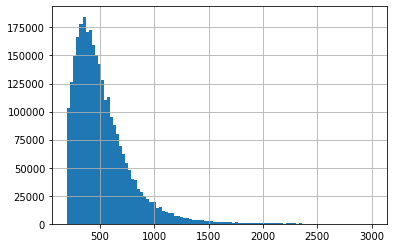

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.932802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 152.8
[100]	valid_0's huber: 135.846
[150]	valid_0's huber: 121.956
[200]	valid_0's huber: 110.949
[250]	valid_0's huber: 102.257
[300]	valid_0's huber: 95.5713
[350]	valid_0's huber: 90.3443
[400]	valid_0's huber: 86.1412
[450]	valid_0's huber: 82.5326
[500]	valid_0's huber: 79.4458
[550]	valid_0's huber: 76.8668
[600]	valid_0's huber: 74.6653
[650]	valid_0's huber: 72.7745
[700]	valid_0's huber: 71.1363
[750]	valid_0's huber: 69.7413
[800]	valid_0's huber: 68.4977
[850]	valid_0's huber: 67.3357
[900]	valid_0's huber: 66.2572
[950]	valid_0's huber: 65.276
[1000]	valid_0's huber: 64.3918
[1050]	valid_0's huber: 63.5837
[1100]	valid_0's huber: 62.8324
[1150]	valid_0's huber: 62.0961
[1200]	valid_0's huber: 61.4383
[1250]	valid_0's huber: 60.8093
[1300]	valid_0's huber: 60.1771
[1350]	valid_0's huber: 59.6367
[1400]	valid_0's huber: 59.126
[1450]	vali

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [23]:
count = 0
for train_idx, val_idx in kf.split(training_data_df):
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 1,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 5000000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    count += 1

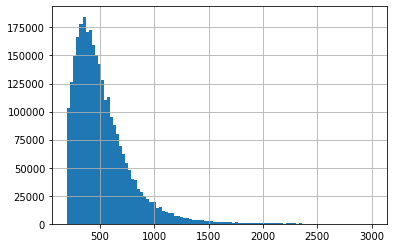

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.974183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.3562
[100]	valid_0's huber: 64.6145
[150]	valid_0's huber: 58.4715
[200]	valid_0's huber: 54.7555
[250]	valid_0's huber: 52.2162
[300]	valid_0's huber: 50.5519
[350]	valid_0's huber: 49.2716
[400]	valid_0's huber: 48.1596
[450]	valid_0's huber: 47.2232
[500]	valid_0's huber: 46.4398
[550]	valid_0's huber: 45.6931
[600]	valid_0's huber: 44.9615
[650]	valid_0's huber: 44.4696
[700]	valid_0's huber: 43.9226
[750]	valid_0's huber: 43.4728
[800]	valid_0's huber: 43.1014
[850]	valid_0's huber: 42.71

<Figure size 432x288 with 0 Axes>

In [24]:
count = 0
for train_idx, val_idx in kf.split(training_data_df):
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    count += 1

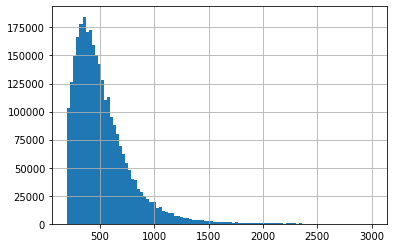

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.958217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 56.0441
[100]	valid_0's huber: 53.683
[150]	valid_0's huber: 52.674
[200]	valid_0's huber: 52.4373
[250]	valid_0's huber: 52.4075
[300]	valid_0's huber: 52.2519
[350]	valid_0's huber: 52.2396
[400]	valid_0's huber: 52.2423
[450]	valid_0's huber: 52.2422
[500]	valid_0's huber: 52.2423
[550]	valid_0's huber: 52.2422
[600]	valid_0's huber: 52.2423
[650]	valid_0's huber: 52.2422
[700]	valid_0's huber: 52.2423
[750]	valid_0's huber: 52.2422
[800]	valid_0's huber: 52.2423
[850]	valid_0's huber: 52.2422

<Figure size 432x288 with 0 Axes>

In [25]:
count = 0
for train_idx, val_idx in kf.split(training_data_df):
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 100,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    count += 1

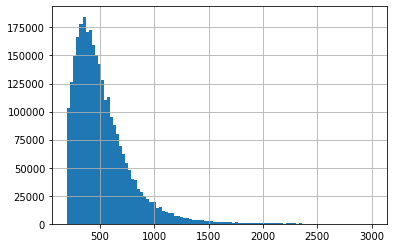

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.934791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.3562
[100]	valid_0's huber: 64.6145
[150]	valid_0's huber: 58.4715
[200]	valid_0's huber: 54.7555
[250]	valid_0's huber: 52.2162
[300]	valid_0's huber: 50.5519
[350]	valid_0's huber: 49.2716
[400]	valid_0's huber: 48.1596
[450]	valid_0's huber: 47.2232
[500]	valid_0's huber: 46.4398
[550]	valid_0's huber: 45.6931
[600]	valid_0's huber: 44.9615
[650]	valid_0's huber: 44.4696
[700]	valid_0's huber: 43.9226
[750]	valid_0's huber: 43.4728
[800]	valid_0's huber: 43.1014
[850]	valid_0's huber: 42.71

<Figure size 432x288 with 0 Axes>

In [26]:
count = 0
for train_idx, val_idx in kf.split(training_data_df):
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 100000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    count += 1

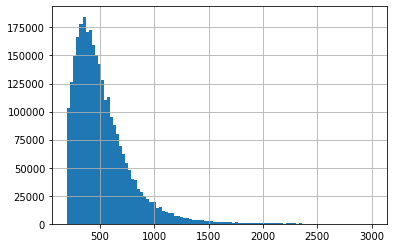

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.907037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 121.87
[100]	valid_0's huber: 95.5178
[150]	valid_0's huber: 82.5599
[200]	valid_0's huber: 74.6693
[250]	valid_0's huber: 69.7728
[300]	valid_0's huber: 66.2289
[350]	valid_0's huber: 63.6039
[400]	valid_0's huber: 61.3862
[450]	valid_0's huber: 59.6067
[500]	valid_0's huber: 58.1323
[550]	valid_0's huber: 56.866
[600]	valid_0's huber: 55.8055
[650]	valid_0's huber: 54.8286
[700]	valid_0's huber: 53.9516
[750]	valid_0's huber: 53.179
[800]	valid_0's huber: 52.4844
[850]	valid_0's huber: 51.8463


[12150]	valid_0's huber: 35.4165
[12200]	valid_0's huber: 35.4042
[12250]	valid_0's huber: 35.3922
[12300]	valid_0's huber: 35.3797
[12350]	valid_0's huber: 35.3727
[12400]	valid_0's huber: 35.3618
[12450]	valid_0's huber: 35.3529
[12500]	valid_0's huber: 35.3473
[12550]	valid_0's huber: 35.3404
[12600]	valid_0's huber: 35.333
[12650]	valid_0's huber: 35.3254
[12700]	valid_0's huber: 35.3171
[12750]	valid_0's huber: 35.307
[12800]	valid_0's huber: 35.2986
[12850]	valid_0's huber: 35.2912
[12900]	valid_0's huber: 35.2831
[12950]	valid_0's huber: 35.2748
[13000]	valid_0's huber: 35.2677
[13050]	valid_0's huber: 35.2601
[13100]	valid_0's huber: 35.2514
[13150]	valid_0's huber: 35.2415
[13200]	valid_0's huber: 35.2298
[13250]	valid_0's huber: 35.223
[13300]	valid_0's huber: 35.2141
[13350]	valid_0's huber: 35.2052
[13400]	valid_0's huber: 35.1974
[13450]	valid_0's huber: 35.1872
[13500]	valid_0's huber: 35.1779
[13550]	valid_0's huber: 35.1669
[13600]	valid_0's huber: 35.1557
[13650]	valid

[24600]	valid_0's huber: 34.4259
[24650]	valid_0's huber: 34.4253
[24700]	valid_0's huber: 34.4248
[24750]	valid_0's huber: 34.4242
[24800]	valid_0's huber: 34.4236
[24850]	valid_0's huber: 34.4232
[24900]	valid_0's huber: 34.423
[24950]	valid_0's huber: 34.423
[25000]	valid_0's huber: 34.4229
[25050]	valid_0's huber: 34.4229
[25100]	valid_0's huber: 34.4229
[25150]	valid_0's huber: 34.4229
[25200]	valid_0's huber: 34.4229
[25250]	valid_0's huber: 34.4229
[25300]	valid_0's huber: 34.4229
[25350]	valid_0's huber: 34.4229
[25400]	valid_0's huber: 34.4229
[25450]	valid_0's huber: 34.4229
[25500]	valid_0's huber: 34.4229
[25550]	valid_0's huber: 34.4229
[25600]	valid_0's huber: 34.4229
[25650]	valid_0's huber: 34.4229
[25700]	valid_0's huber: 34.4228
[25750]	valid_0's huber: 34.4229
[25800]	valid_0's huber: 34.4228
[25850]	valid_0's huber: 34.4228
[25900]	valid_0's huber: 34.4228
[25950]	valid_0's huber: 34.4228
[26000]	valid_0's huber: 34.4228
[26050]	valid_0's huber: 34.4228
[26100]	vali

<Figure size 432x288 with 0 Axes>

In [27]:
count = 0
for train_idx, val_idx in kf.split(training_data_df):
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 3,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 100000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    count += 1

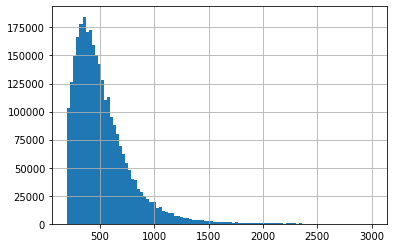

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.915097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 90.1924
[100]	valid_0's huber: 71.2519
[150]	valid_0's huber: 63.6895
[200]	valid_0's huber: 59.213
[250]	valid_0's huber: 56.1058
[300]	valid_0's huber: 53.951
[350]	valid_0's huber: 52.3235
[400]	valid_0's huber: 50.9274
[450]	valid_0's huber: 49.8422
[500]	valid_0's huber: 49.0349
[550]	valid_0's huber: 48.2213
[600]	valid_0's huber: 47.5583
[650]	valid_0's huber: 46.9402
[700]	valid_0's huber: 46.342
[750]	valid_0's huber: 45.784
[800]	valid_0's huber: 45.3517
[850]	valid_0's huber: 44.8498
[

<Figure size 432x288 with 0 Axes>

In [28]:
count = 0
for train_idx, val_idx in kf.split(training_data_df):
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 7,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 100000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    count += 1

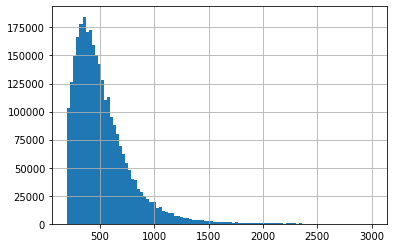

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.927861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 82.3997
[100]	valid_0's huber: 66.3045
[150]	valid_0's huber: 59.7074
[200]	valid_0's huber: 55.9755
[250]	valid_0's huber: 53.3518
[300]	valid_0's huber: 51.5181
[350]	valid_0's huber: 49.9821
[400]	valid_0's huber: 48.8547
[450]	valid_0's huber: 47.8934
[500]	valid_0's huber: 46.9817
[550]	valid_0's huber: 46.2728
[600]	valid_0's huber: 45.5979
[650]	valid_0's huber: 45.0001
[700]	valid_0's huber: 44.41
[750]	valid_0's huber: 43.9471
[800]	valid_0's huber: 43.5021
[850]	valid_0's huber: 43.0866

[12150]	valid_0's huber: 34.6464
[12200]	valid_0's huber: 34.6459
[12250]	valid_0's huber: 34.646
[12300]	valid_0's huber: 34.6453
[12350]	valid_0's huber: 34.6437
[12400]	valid_0's huber: 34.6432
[12450]	valid_0's huber: 34.6423
[12500]	valid_0's huber: 34.642
[12550]	valid_0's huber: 34.6418
[12600]	valid_0's huber: 34.6417
[12650]	valid_0's huber: 34.642
[12700]	valid_0's huber: 34.6419
[12750]	valid_0's huber: 34.6401
[12800]	valid_0's huber: 34.639
[12850]	valid_0's huber: 34.6362
[12900]	valid_0's huber: 34.6361
[12950]	valid_0's huber: 34.6362
[13000]	valid_0's huber: 34.636
[13050]	valid_0's huber: 34.6361
[13100]	valid_0's huber: 34.6342
[13150]	valid_0's huber: 34.6343
[13200]	valid_0's huber: 34.6335
[13250]	valid_0's huber: 34.6339
[13300]	valid_0's huber: 34.6339
[13350]	valid_0's huber: 34.6335
[13400]	valid_0's huber: 34.6335
[13450]	valid_0's huber: 34.6333
[13500]	valid_0's huber: 34.6324
[13550]	valid_0's huber: 34.6326
[13600]	valid_0's huber: 34.6322
[13650]	valid_0

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [29]:
count = 0
for train_idx, val_idx in kf.split(training_data_df):
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 9,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 100000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    count += 1

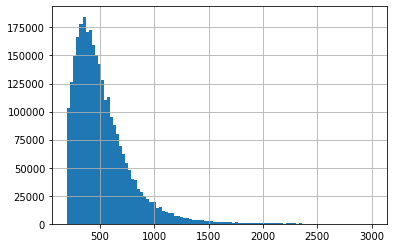

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.902804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10179
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 378
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.3562
[100]	valid_0's huber: 64.6145
[150]	valid_0's huber: 58.4715
[200]	valid_0's huber: 54.7555
[250]	valid_0's huber: 52.2162
[300]	valid_0's huber: 50.5519
[350]	valid_0's huber: 49.2716
[400]	valid_0's huber: 48.1596
[450]	valid_0's huber: 47.2232
[500]	valid_0's huber: 46.4398
[550]	valid_0's huber: 45.6931
[600]	valid_0's huber: 44.9615
[650]	valid_0's huber: 44.4696
[700]	valid_0's huber: 43.9226
[750]	valid_0's huber: 43.4728
[800]	valid_0's huber: 43.1014
[850]	valid_0's huber: 42.71

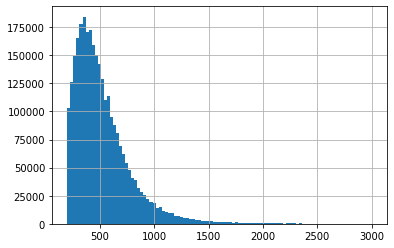

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.946218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10183
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 380
[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4275
[100]	valid_0's huber: 64.6111
[150]	valid_0's huber: 58.1999
[200]	valid_0's huber: 54.5082
[250]	valid_0's huber: 52.2664
[300]	valid_0's huber: 50.5246
[350]	valid_0's huber: 49.0294
[400]	valid_0's huber: 47.9093
[450]	valid_0's huber: 46.9817
[500]	valid_0's huber: 46.195
[550]	valid_0's huber: 45.3935
[600]	valid_0's huber: 44.7129
[650]	valid_0's huber: 44.1256
[700]	valid_0's huber: 43.6551
[750]	valid_0's huber: 43.1622
[800]	valid_0's huber: 42.8101
[850]	valid_0's huber: 42.429

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [30]:
count = 0
for train_idx, val_idx in kf.split(training_data_df):
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_model_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    count += 1

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(bst)

In [ ]:
sample_df = x_valid.sample(n=1000)

In [ ]:
shap_values = explainer.shap_values(sample_df)

In [ ]:
shap_values_df = pd.DataFrame(shap_values)

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df.columns = x_valid.columns

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values(0, ascending=False)

In [ ]:
shap_summary_df.head(50)

In [ ]:
under_zero_df = over_zero_df = shap_summary_df[shap_summary_df[0] <= 0]
under_zero_df.shape

In [ ]:
under_zero_df

In [ ]:
over_zero_df = shap_summary_df[shap_summary_df[0] > 0]
over_zero_df.shape

In [ ]:
over_zero_df = over_zero_df.transpose()
over_zero_df.head()

In [ ]:
over_zero_df.to_csv(basedir + 'over_zero_shap_score_features.csv', index=False)

In [ ]:
selected_features = over_zero_df.columns.tolist()

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
import lightgbm as lgb

In [ ]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse',
    'tree_learner':'feature'
}

In [ ]:
cat_cols = [col for col in cat_cols if col in selected_features]
len(cat_cols)

In [ ]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [ ]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=5000, verbose_eval=50)

In [ ]:
lgb.plot_importance(bst)

In [ ]:
preds = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
bst.save_model('lgb_model_for_training_data_ver_8.txt')

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_training_data_ver_8.csv', index=False)

In [ ]:
pd.DataFrame({'preds':preds}).to_csv('lgb_preds_training_data_ver_8.csv', index=False)

In [ ]:
y_test_pricearea = test_data['가격/면적']

In [ ]:
r2_score(y_test, preds)

In [ ]:
r2_score(y_test_pricearea, np.e**preds)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, preds)

In [ ]:
mean_squared_error(y_test_pricearea, np.e**preds)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'preds':preds})
print(compare_df.shape)
compare_df.head(50)

In [ ]:
compare_df.tail()

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.01)#, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)

In [ ]:
%%time
shap_values = model.get_feature_importance(data=val_pool, type='ShapValues')

In [ ]:
shap_values.shape

In [ ]:
val_pool.shape

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
colnames_map_df = pd.DataFrame({'colnames':x_valid.columns,'map':[i for i in range(len(x_valid.columns))]})
colnames_map_df.head()

In [ ]:
x_valid.columns = colnames_map_df['map'].tolist()
x_valid.head()

In [ ]:
summary = shap.summary_plot(shap_values[:,:-1], x_valid, max_display=x_valid.shape[1])

In [ ]:
shap_values_df = pd.DataFrame(shap_values[:,:-1])
shap_values_df.head()

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
np.mean(np.abs(shap_values_df[0].values))

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values([0], ascending=False)

In [ ]:
shap_summary_df.head()

In [ ]:
selected_features_map = shap_summary_df.index[:330].values

In [ ]:
selected_features_list = []
for v in selected_features_map:
    selected_features_list.append(colnames_map_df.iloc[v,0])

In [ ]:
selected_features_list

In [ ]:
selected_features_df = pd.DataFrame({'colnames':selected_features_list})
selected_features_df.head()

In [ ]:
selected_features_df.to_csv(basedir + 'selected_features.csv', index=False)

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features_list]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features_list]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features_list]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

In [ ]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

In [ ]:
cat_cols = [col for col in x_train.columns if col in cat_cols_list]
len(cat_cols)

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.001, depth=7, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)